# Variáveis Globais

In [573]:
import cx_Oracle
import pandas as pd
import numpy as np
from pandas.compat import StringIO
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from bokeh.sampledata.iris import flowers as dados
import matplotlib.ticker as ticker
import seaborn as sns

PATH = 'C:\\Users\\Inmetrics\\Documents\\Python Scripts\\'
FILE_NAME_D = 'Consumo_Detalhado.csv'
FILE_NAME_M = 'Consumo_Medio.csv'
FILE_NAME_W = 'awrwaitevent.csv'
COLUMNS_D = ['TRACKING_DATE', 'INSTANCE', 'SQLID','MODULE','ELAP','BG','CPU','EXECS','INV','PARSE','DR','ROWS', 'ELAPSQL']
COLUMNS_M = ['RANK_BG','PCT_BG','RANK_DR','PCT_DR','RANK_CPU','PCT_CPU','RANK_ELAP','PCT_ELAP','RANK_PARSE','PCT_PARSE','RANK_EXEC','PCT_EXEC','FLAG','SQL_ID','INSTANCE','BG','DR','CPU','ELAP','PARSE','EXEC','MODULE','SCHEMA']
COLUMNS_W = ['DataHora', 'Evento', 'Tempo(s)', 'Tempo(h)']

# Tratamento de Objetos

In [574]:
def formatdatahora(x):
    return datetime.strptime(x, '%d/%m/%Y %H:%M')

def convToInt(val):
    return int(val) 

def convToFloat(val):
    return float(str.replace(val,',', '.'))

def percentile(n):
    def _percentile(x):
        return np.percentile(x, n)
    _percentile.__name__ = '{}-th percentile'.format(n)
    return _percentile

# Parse Arquivo

In [669]:
df_D = pd.read_csv(PATH + FILE_NAME_D, delimiter=";", names=COLUMNS_D, header=None, na_values='-', skiprows = 1,
                 converters={'TRACKING_DATE': formatdatahora,
                            'INSTANCE': convToInt
#                            'CPU': convToFloat,
#                            'DR': convToFloat,
#                            'BG': convToFloat,
#                            'EXECS': convToFloat
#                            'ELAPSQL': convToFloat
                            }
                ) 
df_D = df_D.set_index('TRACKING_DATE')

df_M = pd.read_csv(PATH + FILE_NAME_M, delimiter=";", names=COLUMNS_M, header=None, na_values='-', skiprows = 1,
                 converters={'INSTANCE': convToInt
#                            'CPU': convToFloat,
#                            'DR': convToFloat,
#                            'BG': convToFloat,
#                            'EXECS': convToFloat
#                            'ELAPSQL': convToFloat
                            }
                ) 
df_M = df_M.set_index('SQL_ID')

df_W = pd.read_csv(PATH + FILE_NAME_W, delimiter=";", names=COLUMNS_W, header=None, na_values='-', skiprows = 1,
                 converters={'DataHora': formatdatahora,
                            'Tempo(s)': convToFloat,
                            'Tempo(h)': convToFloat
                            }
                ) 
df_W = df_W.set_index('DataHora')

# Consumo CPU Time por Módulo

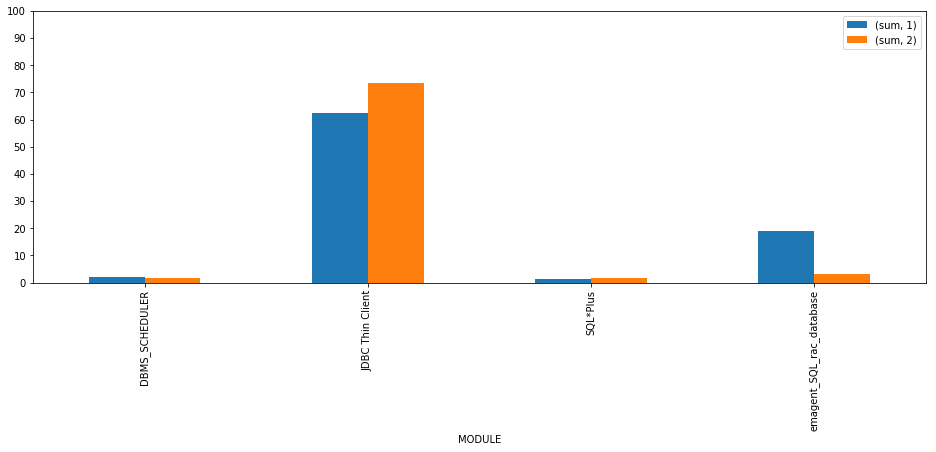

In [711]:
Perc_CPU = df_M
Perc_CPU = Perc_CPU.groupby(['SQL_ID']).agg({    
    'PCT_CPU': ['sum']
})

Perc_Filtro_CPU = Perc_CPU.sort_values(by=[('PCT_CPU', 'sum')], ascending=False)
Perc_Filtro_CPU = Perc_Filtro_CPU.head(10)

Perc_Filtro_CPU = df_M.loc[Perc_Filtro_CPU.index]
Perc_CPU = pd.pivot_table(Perc_Filtro_CPU, index='MODULE', columns = 'INSTANCE' , values='PCT_CPU', aggfunc={'PCT_CPU': ['sum']})
Perc_CPU.head(10).plot.bar(figsize=(16, 5)).tick_params(axis='x', which='major', labelsize=10)
intervalo_eixo = plt.gca().yaxis.major_ticks = np.arange(0, 110, 10)
plt.gca().set_yticks(intervalo_eixo)
plt.legend()

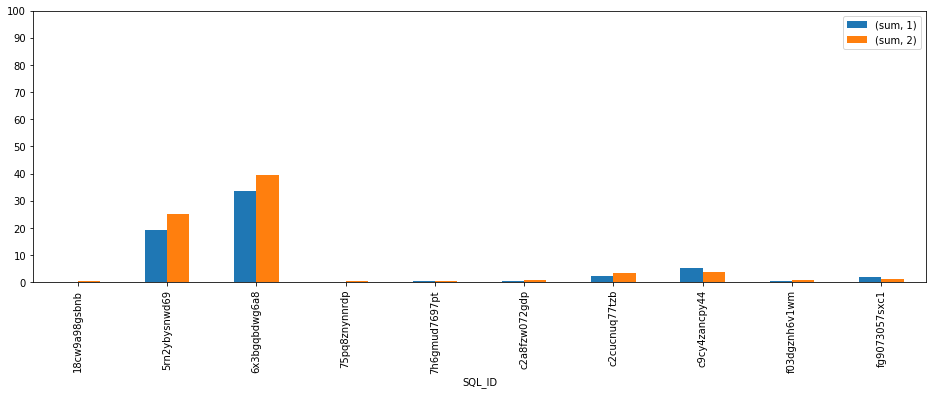

In [716]:
Perc_CPU = df_M.loc[df_M['MODULE'] == 'JDBC Thin Client']
Perc_CPU = Perc_CPU.groupby(['SQL_ID']).agg({    
    'PCT_CPU': ['sum']
})

Perc_Filtro_CPU = Perc_CPU.sort_values(by=[('PCT_CPU', 'sum')], ascending=False)
Perc_Filtro_CPU = Perc_Filtro_CPU.head(10)

Perc_Filtro_CPU = df_M.loc[Perc_Filtro_CPU.index]
Perc_CPU = pd.pivot_table(Perc_Filtro_CPU, index='SQL_ID', columns = 'INSTANCE' , values='PCT_CPU', aggfunc={'PCT_CPU': ['sum']})

Perc_CPU.head(10).plot.bar(figsize=(16, 5)).tick_params(axis='x', which='major', labelsize=10)
intervalo_eixo = plt.gca().yaxis.major_ticks = np.arange(0, 110, 10)
plt.gca().set_yticks(intervalo_eixo)
plt.legend()

## Gráfico Consumo de CPU

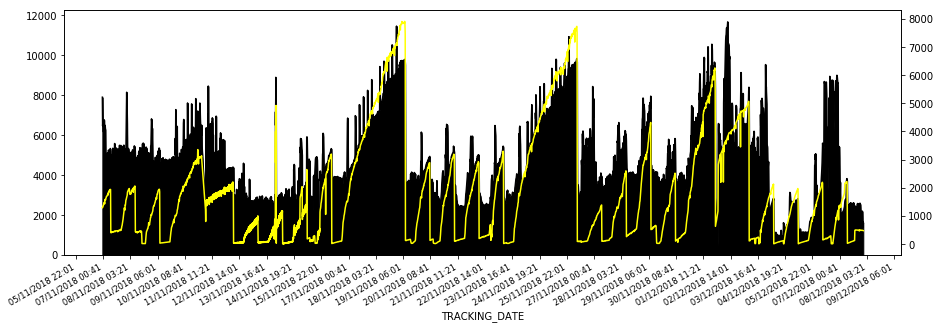

In [745]:
Consumo_CPUSQL = df_D.loc[df_D['SQLID'] == '6x3bgqbdwg6a8']
Consumo_CPUSQL = Consumo_CPUSQL.groupby(['TRACKING_DATE']).agg({    
    'CPU': ['sum']
})

Consumo_CPU = df_D
Consumo_CPU = Consumo_CPU.groupby(['TRACKING_DATE']).agg({    
    'CPU': ['sum']
})

Consumo_CPU[('CPU', 'sum')].plot.area(figsize=(15, 5), colormap='gray')
plt.xticks(size='small',rotation=90, ha="right")
Consumo_CPUSQL[('CPU', 'sum')].plot.line(figsize=(15, 5),secondary_y=True, colormap='gnuplot_r')
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%d/%m/%Y %H:%M'))
plt.xticks(size='small',rotation=90, ha="right")
plt.gca().xaxis.set_major_locator(dates.MinuteLocator(byminute=None, interval=1600))

# Tempo de Execução por SQLID

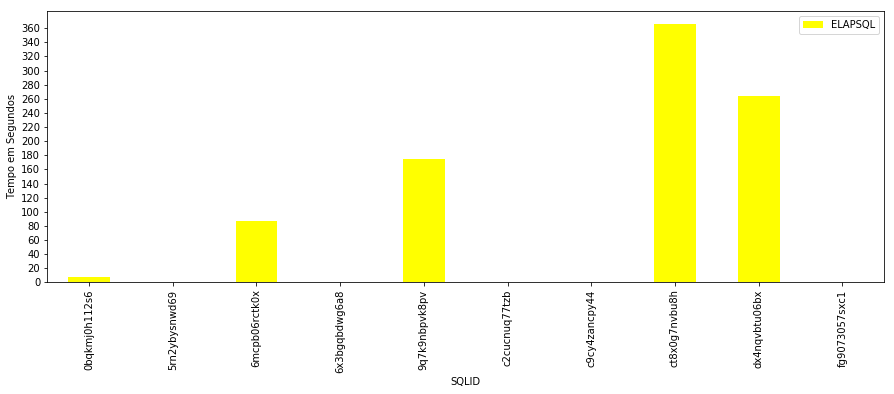

In [523]:
TempoExecFiltro = Consumo_CPU.sort_values(by=[('CPU', 'sum')],ascending=False)
TempoExecFiltro = Consumo_CPU.loc[TempoExecFiltro.index]
TempoExecFiltro = TempoExecFiltro.head(10)

TempoExec = df_D.loc[df_D['SQLID'].isin(TempoExecFiltro.index)]
TempoExec = TempoExec.groupby(['SQLID']).agg({    
    'ELAPSQL': np.mean
})

TempoExec.plot.bar(figsize=(15, 5), colormap='gnuplot_r').tick_params(axis='x', which='major', labelsize=10)
plt.ylabel("Tempo em Segundos")
intervalo_eixo = plt.gca().yaxis.major_ticks = np.arange(min(TempoExec['ELAPSQL']), max(TempoExec['ELAPSQL']), 20)
plt.gca().set_yticks(intervalo_eixo)
plt.legend()

# Balanceamento Execuções

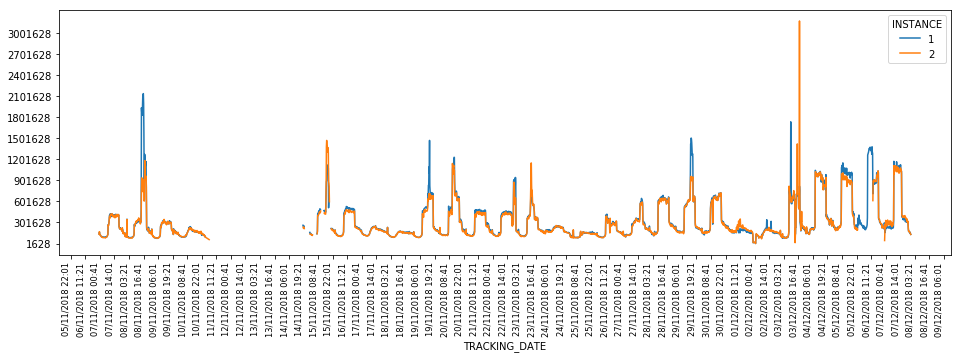

In [505]:
Qtde_Execs = df_D.groupby(['TRACKING_DATE','INSTANCE']).agg({    
    'EXECS': np.sum
})

GraficoE = pd.pivot_table(Qtde_Execs, index='TRACKING_DATE', columns = 'INSTANCE' , values='EXECS', aggfunc={'EXECS': np.sum})
GraficoE.plot.line(figsize=(16, 5)).tick_params(axis='x', which='major', labelsize=5)
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%d/%m/%Y %H:%M'))
plt.xticks(size='small',rotation=90, ha="right")
intervalo_eixo = plt.gca().yaxis.major_ticks = np.arange(min(Qtde_Execs['EXECS']), max(Qtde_Execs['EXECS']), 300000)
plt.gca().set_yticks(intervalo_eixo)
plt.gca().xaxis.set_major_locator(dates.MinuteLocator(byminute=None, interval=800))

# Tempo vs Execução

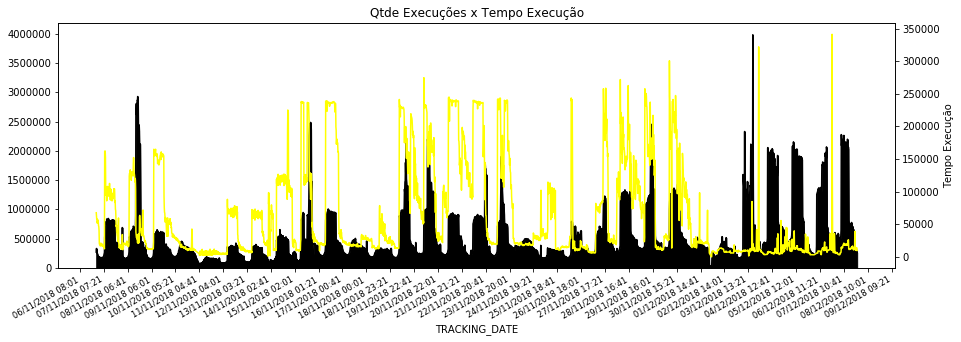

In [12]:
Qtde_Execs = df_D
Qtde_Execs = Qtde_Execs.groupby(['TRACKING_DATE']).agg({    
    'EXECS': ['sum'],
    'ELAP': ['sum']
})

Qtde_Execs[('EXECS', 'sum')].plot.area(figsize=(15, 5), colormap='gray')
plt.xticks(size='small',rotation=90, ha="right")
Qtde_Execs[('ELAP', 'sum')].plot(figsize=(15, 5),secondary_y=True, colormap='gnuplot_r')
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%d/%m/%Y %H:%M'))
plt.ylabel("Tempo Execução")
plt.title("Qtde Execuções x Tempo Execução")
plt.gca().xaxis.set_major_locator(dates.MinuteLocator(byminute=None, interval=1400))

# Eventos de Espera

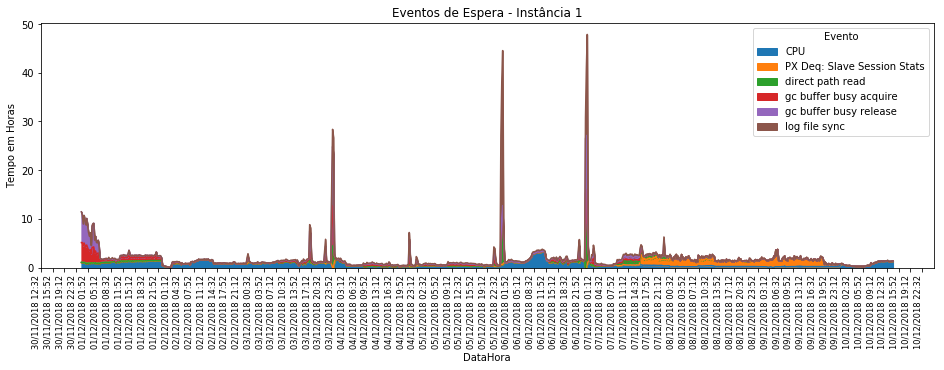

In [7]:
NmEvent = df_W.groupby(['Evento'], sort=True).agg({    
    'Tempo(h)': ['sum']
})

NmEvent = NmEvent.sort_values(by=[('Tempo(h)', 'sum')], ascending=False)
NmEvent = NmEvent.reset_index()
NmEvent = NmEvent['Evento'].head(6)

df_W_Filtro = df_W.loc[(df_W['Evento'].isin(NmEvent))]

df_W_Filtro = df_W_Filtro.groupby(['DataHora', 'Evento'], sort=True).agg({'Tempo(h)': np.sum})

GraficoW = pd.pivot_table(df_W_Filtro, index='DataHora', columns = {'Evento'} , values='Tempo(h)', aggfunc={'Tempo(h)': np.sum})
GraficoW.plot.area(figsize=(16, 5)).tick_params(axis='x', which='major', labelsize=5)
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%d/%m/%Y %H:%M'))
plt.xticks(size='small',rotation=90, ha="right")
plt.title("Eventos de Espera - Instância 1")
plt.ylabel("Tempo em Horas")
plt.gca().xaxis.set_major_locator(dates.MinuteLocator(byminute=None, interval=200))

In [1]:

# IPython 
import IPython
from IPython.core.display import HTML
from IPython.display import Image



#                 Run (once) to allow nice html output as report (optional) 


"""
Hide code cells in an IPython notebook or exported HTML using javascript. 
Taken from Max Masnick's answer in 
http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer.
"""

# Example: di.display_html('<h3>%s:</h3>' % str, raw=True)
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html(
    '<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area, .output_stderr").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

CSS = """.input_area .output_stderr {height: 2.0em; overflow: hidden}"""  # changes input_subarea width to 1 visible line
HTML('<style>{}</style>'.format(CSS))

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Click in rendered .html output only, toggles the code</button>''', raw=True)

Click in rendered .html output only, toggles the code

In [11]:
strTexto

NameError: name 'strTexto' is not defined